<a id="top"></a>
# 03_TRAIN_CONTINUAL — Entrenamiento Continual con *presets*

**Qué hace este notebook**  
Entrena y evalúa modelos en **aprendizaje continual** (secuencia de tareas) usando una **configuración unificada** desde `configs/presets.yaml`. Permite:  
1) lanzar un *run* base con el método del preset,  
2) **comparar métodos** manteniendo fijos datos/modelo, y  
3) generar un **resumen agregado** de resultados en `outputs/summary/`.


---

## 🎯 Objetivos
- Centralizar la configuración de **modelo**, **datos/codificación temporal**, **optimizador** y **método continual** vía `presets.yaml`.
- Soportar **H5 offline** (si `use_offline_spikes: true`) o **CSV + codificación en runtime** (si `encode_runtime: true`), seleccionándolo de forma coherente con el preset.
- Comparar métodos (`naive`, `ewc`, `rehearsal`, `rehearsal+ewc`, y los bio-inspirados previstos: `as-snn`, `sa-snn`, `sca-snn`, `colanet`) con **idéntica preparación de datos**.
- Exportar un **CSV de agregados** con métricas clave (MAE/MSE por tarea, olvido absoluto/relativo, etc.).

## ✅ Prerrequisitos
- Haber generado `data/processed/tasks.json` (y opcionalmente `tasks_balanced.json`) con **01_DATA_QC_PREP** o **01A_PREP_BALANCED**.
- Si el preset usa **offline** (`use_offline_spikes: true`), haber creado los H5 compatibles con **02_ENCODE_OFFLINE** (mismo `encoder/T/gain/size/to_gray` que el preset).
- Revisar `configs/presets.yaml` (secciones `model`, `data`, `optim`, `continual`, `prep`).

## ⚠️ Notas importantes
- **No combines** `use_offline_spikes: true` y `encode_runtime: true`. El notebook lo detecta y lanza error.
- La **semilla** global se toma de `CFG["data"]["seed"]` para reproducibilidad.
- La carpeta de salida incluye en el nombre preset, método, *encoder*, modelo, *seed*, etc., para facilitar trazabilidad.

<a id="toc"></a>

## 🧭 Índice

- [1) Setup del entorno y paths](#sec-01)  
- [2) Carga del preset unificado (`configs/presets.yaml`)](#sec-02)  
- [3) Verificación de datos y selección de `tasks.json`](#sec-03)  
- [4) Factories DataLoaders + Modelo (+ tasks)](#sec-04)  
- [5) Ejecución base con el preset (eco de config + run)](#sec-06)  
- [6) Comparativa de métodos (mismo preset/semilla/datos)](#sec-07)  
- [7) Barrido de combinaciones (opcional)](#sec-08)  
- [8) Resumen completo: inventario → parseo → agregados → tabla](#sec-09)



<a id="sec-01"></a>
## 1) Setup del entorno y paths

**Objetivo**  
Preparar el entorno: limitar hilos BLAS (evitar *oversubscription*), detectar `ROOT` (raíz del repo) y añadirlo a `sys.path`, importar utilidades del proyecto y seleccionar dispositivo (`cuda` si está disponible). Se activan optimizaciones de PyTorch en GPU (TF32/cuDNN) para acelerar.

> Aquí **no** se leen aún los presets; solo se configura el runtime global. 

[↑ Volver al índice](#toc)

In [1]:
# =============================================================================
# 0) Entorno (poner ANTES de importar torch)
# =============================================================================
import os

# Logging opcional (lo usa tu training.py)
os.environ["TRAIN_LOG_ITPS"] = "1"

# Depuración rara de kernels (déjalo comentado):
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
# =============================================================================
# 1) Setup del entorno y paths
# =============================================================================
from pathlib import Path
import sys, gc, time, json, re
import torch

# Robustez multiproceso/WSL
try:
    import torch.multiprocessing as mp
    mp.set_sharing_strategy("file_system")
except Exception:
    pass

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.datasets import ImageTransform, AugmentConfig
from src.models   import build_model
from src.utils    import load_preset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("OUT :", OUT)
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


ROOT: /home/cesar/proyectos/TFM_SNN
OUT : /home/cesar/proyectos/TFM_SNN/outputs
Device: cuda
GPU: NVIDIA GeForce RTX 4080 Laptop GPU


<a id="sec-02"></a>

## 2) Carga del preset unificado (`configs/presets.yaml`)

**Objetivo**  
Cargar un **preset** (`fast` | `std` | `accurate`) y derivar toda la configuración operativa:

- **Modelo/transform**: tamaño de imagen, escala de grises, etc.
- **Datos/codificación**: `encoder` (`rate|latency|raw`), `T`, `gain`, `seed`.
- **DataLoader**: `num_workers`, `prefetch_factor`, `pin_memory`, `persistent_workers`.
- **Augment** opcional y **balanceo online** si procede.

Incluye un **guardarraíl**: si `use_offline_spikes: true` y `encode_runtime: true` están ambos activos, se aborta con un error claro (config inválida).  

[↑ Volver al índice](#toc)

In [3]:
# =============================================================================
# 2) Utils de limpieza y diagnóstico de memoria
# =============================================================================
def cuda_mem():
    if torch.cuda.is_available():
        try: torch.cuda.synchronize()
        except Exception: pass
        alloc = torch.cuda.memory_allocated() / (1024**2)
        reserv = torch.cuda.memory_reserved() / (1024**2)
        return f"{alloc:.0f} MiB alloc | {reserv:.0f} MiB reserved"
    return "CPU-only"

def clear_cuda():
    try: torch.cuda.synchronize()
    except Exception: pass
    try: torch.cuda.empty_cache()
    except Exception: pass
    try: torch.cuda.ipc_collect()
    except Exception: pass
    gc.collect()

def detach_method_like(obj):
    """Desengancha hooks si existen (detach/close)."""
    if obj is None:
        return
    for attr in ("detach", "close"):
        if hasattr(obj, attr):
            try: getattr(obj, attr)()
            except Exception: pass

def teardown_run(tfm_obj, extras=()):
    """Suelta método/tfm, borra refs grandes y limpia CUDA."""
    try:
        # Por si tfm_obj expone método/continual con hooks
        detach_method_like(tfm_obj)
        for maybe in (getattr(tfm_obj, "method", None),
                      getattr(tfm_obj, "continual", None)):
            detach_method_like(maybe)
    except Exception:
        pass
    for x in extras:
        try: del x
        except Exception: pass
    clear_cuda()

print("CUDA mem @start:", cuda_mem())


CUDA mem @start: 0 MiB alloc | 0 MiB reserved


<a id="sec-03"></a>

## 3) Verificación de datos y selección de `tasks.json`

**Objetivo**  
Construir `task_list` y verificar que existen los *splits* por tarea:

- Si el preset pide **balanced** (`prep.use_balanced_tasks: true`) y existe `tasks_balanced.json`, se usa; en caso contrario, se cae a `tasks.json` (se informa).
- Se valida que `train/val/test.csv` existen para cada *run*.  
- Si entrenas con **H5 offline**, se comprueba que están presentes los H5 con **nomenclatura compatible** con el preset (`encoder/T/gain/size/to_gray`).

> Si falta algún H5 requerido, genera primero con **02_ENCODE_OFFLINE**.  

[↑ Volver al índice](#toc)

In [4]:
# =============================================================================
# 3) Carga del preset (configs/presets.yaml)
# =============================================================================
PRESET = "fast"  # "fast" para humo, "accurate" para resultados
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

# ---- Modelo / Transform ----
MODEL_NAME = CFG["model"]["name"]
tfm = ImageTransform(
    CFG["model"]["img_w"],
    CFG["model"]["img_h"],
    to_gray=bool(CFG["model"]["to_gray"]),
    crop_top=None,
)

# ---- Datos / codificación ----
ENCODER = CFG["data"]["encoder"]
T       = int(CFG["data"]["T"])
GAIN    = float(CFG["data"]["gain"])
SEED    = int(CFG["data"]["seed"])

USE_OFFLINE_SPIKES = bool(CFG["data"].get("use_offline_spikes", False))
RUNTIME_ENCODE     = bool(CFG["data"].get("encode_runtime", False))

# ---- Loader / augment / balanceo ----
NUM_WORKERS = int(CFG["data"].get("num_workers") or 0)
PREFETCH    = int(CFG["data"].get("prefetch_factor") or 2)
PIN_MEMORY  = bool(CFG["data"].get("pin_memory", True))
PERSISTENT  = bool(CFG["data"].get("persistent_workers", True))

AUG_CFG = AugmentConfig(**(CFG["data"].get("aug_train") or {})) \
          if CFG["data"].get("aug_train") else None

USE_ONLINE_BALANCING = bool(CFG["data"].get("balance_online", False))
BAL_BINS = int(CFG["data"].get("balance_bins") or 50)
BAL_EPS  = float(CFG["data"].get("balance_smooth_eps") or 1e-3)

if USE_OFFLINE_SPIKES and RUNTIME_ENCODE:
    raise RuntimeError("Config inválida: use_offline_spikes=True y encode_runtime=True a la vez.")

print(f"[PRESET={PRESET}] model={MODEL_NAME} {tfm.w}x{tfm.h} gray={tfm.to_gray}")
print(f"[DATA] encoder={ENCODER} T={T} gain={GAIN} seed={SEED}")
print(f"[LOADER] workers={NUM_WORKERS} prefetch={PREFETCH} pin={PIN_MEMORY} persistent={PERSISTENT}")
print(f"[BALANCE] online={USE_ONLINE_BALANCING} bins={BAL_BINS} eps={BAL_EPS}")
print(f"[RUNTIME_ENCODE] {RUNTIME_ENCODE} | [OFFLINE_SPIKES] {USE_OFFLINE_SPIKES}")


[PRESET=fast] model=pilotnet_snn 200x66 gray=True
[DATA] encoder=rate T=10 gain=0.5 seed=42
[LOADER] workers=6 prefetch=2 pin=True persistent=False
[BALANCE] online=False bins=50 eps=0.001
[RUNTIME_ENCODE] False | [OFFLINE_SPIKES] True


<a id="sec-04"></a>
## 4) Factories unificados: DataLoaders + Modelo (+ tasks)

**Objetivo**  
Crear, en una sola llamada, los **componentes coherentes con el preset**:

- `build_components_for(CFG, ROOT)` → devuelve `tfm`, `make_loader_fn`, `make_model_fn`.
  - El **loader** respeta automáticamente el modo datos (H5 offline vs. CSV+encode runtime), *workers/prefetch/pin/persistent*, *augment*, y **balanceo online** si está activo.
  - El **modelo** se instancia según `model.name` y parámetros asociados.
- `build_task_list_for(CFG, ROOT)` → devuelve `task_list` y el *tasks file* efectivamente usado.

> Con esto evitas duplicar lógica entre cuadernos y garantizas que **bench, entrenamiento y comparativa** usen la **misma** configuración.  

[↑ Volver al índice](#toc)


In [5]:
# =============================================================================
# 4) Verificación de datos (splits y, si procede, H5)
# =============================================================================
import json
from pathlib import Path as _P

PROC = ROOT / "data" / "processed"
USE_BALANCED = bool(CFG.get("prep", {}).get("use_balanced_tasks", False))
tb_name = (CFG.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
t_name  = (CFG.get("prep", {}).get("tasks_file_name") or "tasks.json")

cand_bal = PROC / tb_name
cand_std = PROC / t_name
TASKS_FILE = cand_bal if (USE_BALANCED and cand_bal.exists()) else cand_std

with open(TASKS_FILE, "r", encoding="utf-8") as f:
    tasks_json = json.load(f)

task_list = [{"name": n, "paths": tasks_json["splits"][n]} for n in tasks_json["tasks_order"]]
print("Usando:", TASKS_FILE.name)
for t in task_list:
    print(f" - {t['name']}: {_P(t['paths']['train']).name}")

if USE_BALANCED:
    for t in task_list:
        train_path = _P(tasks_json["splits"][t["name"]]["train"])
        if train_path.name != "train_balanced.csv":
            raise RuntimeError(
                f"[{t['name']}] Esperaba 'train_balanced.csv' en modo balanced, pero encontré '{train_path.name}'."
            )

if USE_OFFLINE_SPIKES:
    mw, mh = CFG["model"]["img_w"], CFG["model"]["img_h"]
    color = "gray" if CFG["model"]["to_gray"] else "rgb"
    gain_tag = (GAIN if ENCODER == "rate" else 0)
    missing = []
    for t in task_list:
        base = PROC / t["name"]
        for split in ("train", "val", "test"):
            expected = base / f"{split}_{ENCODER}_T{T}_gain{gain_tag}_{color}_{mw}x{mh}.h5"
            if not expected.exists():
                missing.append(str(expected))
    if missing:
        print("[WARN] Faltan H5 compatibles con el preset. Genera con 02_ENCODE_OFFLINE.")
print("OK: verificación de splits.")


Usando: tasks_balanced.json
 - circuito1: train_balanced.csv
 - circuito2: train_balanced.csv
OK: verificación de splits.


<a id="sec-05"></a>
## 5) Ejecución base con el preset (eco de config + run)

**Objetivo**  
Lanzar **un experimento** con el método y parámetros del preset (`CFG["continual"]`). La celda:

- Imprime un **resumen de configuración** (modelo, datos, loader, método).
- Ejecuta `run_continual(...)`.
- Guarda resultados en `outputs/continual_*` (incluye `continual_results.json` y `manifest.json` por tarea).

> Revisa la consola para confirmar dispositivo, *encoder/T/gain* y modo de datos (offline/ runtime).  

[↑ Volver al índice](#toc)

In [6]:
# =============================================================================
# 5) Factories: DataLoaders + Modelo + task_list
# =============================================================================
from src.utils import build_task_list_for, build_components_for

tfm, make_loader_fn, make_model_fn = build_components_for(CFG, ROOT)
task_list, tasks_file = build_task_list_for(CFG, ROOT)
print("Tasks file:", tasks_file.name)
print("make_loader_fn listo (usa H5 si offline; si no, CSV + encode runtime).")


Tasks file: tasks_balanced.json
make_loader_fn listo (usa H5 si offline; si no, CSV + encode runtime).


<a id="sec-06"></a>
## 6) Comparativa de métodos (mismo preset / misma semilla / mismos datos)

**Objetivo**  
Ejecutar una **batería de métodos** cambiando **solo** `continual.method` y sus `params`, manteniendo fijos: preset, semilla, *encoder/T/gain*, tamaño de imagen, *augment*, etc.

- Se clona `CFG` por método y se invoca `run_continual(...)` con las **factories** del propio `cfg_i`.
- El diccionario `METHODS` puede ampliarse con nombres registrados en `src/methods/`:
  - `naive`, `ewc`, `rehearsal`, `rehearsal+ewc`
  - (bio-inspirados previstos) `as-snn`, `sa-snn`, `sca-snn`, `colanet`

**Recomendaciones**
- Si usas **offline H5**, asegúrate de que existen para el preset (`02_ENCODE_OFFLINE`).
- Si activas *replay* (rehearsal), puedes **reducir** `persistent_workers` para evitar atascos de DataLoader en algunos entornos; la celda ya lo ajusta como precaución.

[↑ Volver al índice](#toc)

In [7]:
# =============================================================================
# 6) Barrido "mejor por método" (accurate, T=30, B=160)
# =============================================================================
from copy import deepcopy
from pathlib import Path
import sys
from src.runner import run_continual
from src.utils  import load_preset, build_task_list_for, build_components_for

# Re-cargo preset limpio (por si tocamos el dict en el loop)
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

print("[SANITY] torch:", torch.__version__, "| cuda:", torch.cuda.is_available(),
      "| dev_count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("[SANITY] device:", torch.cuda.current_device(),
          "|", torch.cuda.get_device_name(torch.cuda.current_device()))
print("[SANITY] CFG.optim.amp =", CFG["optim"].get("amp", None))

# === Selección de runs (modula aquí) ===
EXPS = [
    # SCA-SNN ganador previo (tu mejor actual)
    dict(
        method="sca-snn",
        params={
            "attach_to": "f6",
            "flatten_spatial": False,
            "num_bins": 50,
            "anchor_batches": 16,
            "beta": 0.60,
            "bias": 0.05,
            "soft_mask_temp": 0.50,
            "verbose": False,
            "log_every": 65536
        },
        tag="best_sca_b060_bias005_t050_ab16"
    ),

    # Línea base naive (útil para sanity y comparar footprint)
    dict(method="naive", params={}, tag="baseline_naive"),
]

EXPS = [
    # ---------- SCA-SNN (Similarity/Context-Aware gating) ----------
    # Base actual (referencia)
    # dict(
    #     method="sca-snn",
    #     params={"attach_to":"f6","flatten_spatial":False,"num_bins":50,"anchor_batches":16,
    #             "beta":0.60,"bias":0.05,"soft_mask_temp":0.50,"verbose":False,"log_every":65536},
    #     tag="sca_ref_b060_bias005_t050_ab16"
    # ),
    # SCA-1: gating más laxo (puede reducir olvido a costa de algo de MAE)
    dict(
        method="sca-snn",
        params={"attach_to":"f6","flatten_spatial":False,"num_bins":50,"anchor_batches":16,
                "beta":0.55,"bias":0.00,"soft_mask_temp":0.30,"verbose":False,"log_every":65536},
        tag="sca_looser_b055_bias000_t030_ab16"
    ),
    # SCA-2: gating más estricto y anclas más finas (puede bajar MAE si no estrangula)
    dict(
        method="sca-snn",
        params={"attach_to":"f6","flatten_spatial":False,"num_bins":80,"anchor_batches":16,
                "beta":0.65,"bias":0.05,"soft_mask_temp":0.00,"verbose":False,"log_every":65536},
        tag="sca_hard_b065_bias005_t000_bins80"
    ),
    # SCA-3: más anclas (estabilidad de bins), bias mayor para reuso “conservador”
    dict(
        method="sca-snn",
        params={"attach_to":"f6","flatten_spatial":False,"num_bins":50,"anchor_batches":24,
                "beta":0.60,"bias":0.10,"soft_mask_temp":0.50,"verbose":False,"log_every":65536},
        tag="sca_moreanchors_b060_bias010_t050_ab24"
    ),

    # ---------- SA-SNN (Sparse Selective Activation) ----------
    # Ref (tu “best_sa_k8_tau28_p2m”)
    dict(
        method="sa-snn",
        params={"attach_to":"f6","k":8,"tau":28.0,"th_min":1.0,"th_max":2.0,
                "p":2_000_000,"vt_scale":1.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False},
        tag="sa_ref_k8_tau28_p2m"
    ),
    # SA-1: algo más agresivo en selectividad (k menos, tau menor)
    dict(
        method="sa-snn",
        params={"attach_to":"f6","k":6,"tau":24.0,"th_min":1.0,"th_max":2.0,
                "p":2_000_000,"vt_scale":1.2,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False},
        tag="sa_k6_tau24_vt1p2"
    ),
    # SA-2: k mayor + tau mayor (más estabilidad, posible mejor MAE; vigilar olvido)
    dict(
        method="sa-snn",
        params={"attach_to":"f6","k":10,"tau":32.0,"th_min":1.0,"th_max":2.0,
                "p":5_000_000,"vt_scale":1.0,"flatten_spatial":False,
                "assume_binary_spikes":False,"reset_counters_each_task":False},
        tag="sa_k10_tau32_p5m"
    ),
    # SA-3: probar flatten_spatial=True (menos memoria y distinta granularidad)
    dict(
        method="sa-snn",
        params={"attach_to":"f6","k":8,"tau":28.0,"th_min":1.0,"th_max":2.0,
                "p":2_000_000,"vt_scale":1.0,"flatten_spatial":True,
                "assume_binary_spikes":False,"reset_counters_each_task":False},
        tag="sa_k8_tau28_flatten"
    ),

    # ---------- AS-SNN (Adaptive Synaptic Scaling + actividad) ----------
    # Ref (tu mejor AS con f6/modules, L1, sin scaling)
    dict(
        method="as-snn",
        params={"gamma_ratio":0.30,"lambda_a":1.59168,"ema":0.90,
                "attach_to":"f6","measure_at":"modules","penalty_mode":"l1",
                "do_synaptic_scaling":False},
        tag="as_ref_gr03_lam1p59168"
    ),
    # AS-1: reduce gamma_ratio (menos penalización actividad -> menor olvido)
    dict(
        method="as-snn",
        params={"gamma_ratio":0.25,"lambda_a":1.20,"ema":0.90,
                "attach_to":"f6","measure_at":"modules","penalty_mode":"l1",
                "do_synaptic_scaling":False},
        tag="as_soft_gr025_lam1p20"
    ),
    # AS-2: activa synaptic_scaling (reajuste por tarea) + EMA más alta
    dict(
        method="as-snn",
        params={"gamma_ratio":0.35,"lambda_a":1.80,"ema":0.95,
                "attach_to":"f6","measure_at":"modules","penalty_mode":"l1",
                "do_synaptic_scaling":True,"scale_clip":(0.5,2.0),"scale_bias":False},
        tag="as_scaling_gr035_lam1p80_ema095"
    ),

    # ---------- Línea base ----------
    dict(method="naive", params={}, tag="baseline_naive"),
]

EXPS = [
    # AS-2: activa synaptic_scaling (reajuste por tarea) + EMA más alta
    dict(
        method="as-snn",
        params={"gamma_ratio":0.35,"lambda_a":1.80,"ema":0.95,
                "attach_to":"f6","measure_at":"modules","penalty_mode":"l1",
                "do_synaptic_scaling":True,"scale_clip":(0.5,2.0),"scale_bias":False},
        tag="as_scaling_gr035_lam1p80_ema095"
    ),

    # ---------- Línea base ----------
    dict(method="naive", params={}, tag="baseline_naive"),
]


# Dataloader “seguro” (si aún ves fugas, pon True):
SAFE_DATALOADER_FOR_ALL = False   # si True: num_workers=0 y sin persistentes
SLEEP_BETWEEN_RUNS_SEC  = 1.0

OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

print("CUDA before loop:", cuda_mem()); clear_cuda()
runs_out = []

for idx, exp in enumerate(EXPS, start=1):
    method_name   = exp["method"]
    method_params = exp["params"]

    cfg_i = deepcopy(CFG)
    cfg_i["continual"]["method"] = method_name
    cfg_i["continual"]["params"] = method_params
    cfg_i.setdefault("naming", {})
    cfg_i["naming"]["tag"] = exp["tag"]

    # Seguridad dataloader en WSL/Windows: evita workers persistentes (fuga típica)
    cfg_i["data"]["persistent_workers"] = False
    if SAFE_DATALOADER_FOR_ALL:
        cfg_i["data"]["num_workers"] = 0
        cfg_i["data"]["pin_memory"]  = False

    tfm_i, make_loader_fn_i, make_model_fn_i = build_components_for(cfg_i, ROOT)
    task_list_i, tasks_file_i = build_task_list_for(cfg_i, ROOT)

    print(f"\n=== RUN {idx}/{len(EXPS)} preset={PRESET} : method={method_name} | tag={exp['tag']} ===")
    print("CUDA pre-run:", cuda_mem())

    try:
        out_dir, _ = run_continual(
            task_list=task_list_i,
            make_loader_fn=make_loader_fn_i,
            make_model_fn=make_model_fn_i,
            tfm=tfm_i,
            cfg=cfg_i,
            preset_name=PRESET,
            out_root=OUT,
            verbose=True,
        )
        runs_out.append(out_dir)
        print("[OK]", out_dir)
    except Exception as e:
        print(f"[ERROR] Falló method={method_name} tag={exp['tag']}: {type(e).__name__}: {e}")
    finally:
        # Desmontaje FUERTE entre runs
        teardown_run(
            tfm_i,
            extras=(make_loader_fn_i, make_model_fn_i, task_list_i, tasks_file_i, cfg_i)
        )
        print("CUDA post-run:", cuda_mem())
        time.sleep(SLEEP_BETWEEN_RUNS_SEC)

print("\nHecho:", [str(p) for p in runs_out])
print("CUDA after loop:", cuda_mem())


[SANITY] torch: 2.8.0+cu129 | cuda: True | dev_count: 1
[SANITY] device: 0 | NVIDIA GeForce RTX 4080 Laptop GPU
[SANITY] CFG.optim.amp = True
CUDA before loop: 0 MiB alloc | 0 MiB reserved

=== RUN 1/2 preset=fast : method=as-snn | tag=as_scaling_gr035_lam1p80_ema095 ===
CUDA pre-run: 0 MiB alloc | 0 MiB reserved

--- Tarea 1/2: circuito1 | preset=fast | method=as-snn_gr_0.35_lam_1.8_att_f6_scale_on | B=384 T=10 AMP=True | enc=rate ---


[TRAIN it/s] epoch 1/2: 2.5 it/s  (66 iters en 26.32s)


[TRAIN it/s] epoch 2/2: 3.3 it/s  (66 iters en 19.82s)



--- Tarea 2/2: circuito2 | preset=fast | method=as-snn_gr_0.35_lam_1.8_att_f6_scale_on | B=384 T=10 AMP=True | enc=rate ---


[TRAIN it/s] epoch 1/2: 2.6 it/s  (29 iters en 11.08s)


[TRAIN it/s] epoch 2/2: 2.9 it/s  (29 iters en 10.14s)


[OK] /home/cesar/proyectos/TFM_SNN/outputs/continual_fast_as-snn_gr_0.35_lam_1.8_att_f6_scale_on_as_scaling_gr035_lam1p80_ema095_rate_model-PilotNetSNN_66x200_gray_seed_42
CUDA post-run: 307 MiB alloc | 620 MiB reserved

=== RUN 2/2 preset=fast : method=naive | tag=baseline_naive ===
CUDA pre-run: 307 MiB alloc | 620 MiB reserved

--- Tarea 1/2: circuito1 | preset=fast | method=naive | B=384 T=10 AMP=True | enc=rate ---


[TRAIN it/s] epoch 1/2: 3.4 it/s  (66 iters en 19.30s)


[TRAIN it/s] epoch 2/2: 3.4 it/s  (66 iters en 19.41s)



--- Tarea 2/2: circuito2 | preset=fast | method=naive | B=384 T=10 AMP=True | enc=rate ---


[TRAIN it/s] epoch 1/2: 3.0 it/s  (29 iters en 9.57s)


[TRAIN it/s] epoch 2/2: 3.1 it/s  (29 iters en 9.37s)


[OK] /home/cesar/proyectos/TFM_SNN/outputs/continual_fast_naive_baseline_naive_rate_model-PilotNetSNN_66x200_gray_seed_42
CUDA post-run: 598 MiB alloc | 946 MiB reserved

Hecho: ['/home/cesar/proyectos/TFM_SNN/outputs/continual_fast_as-snn_gr_0.35_lam_1.8_att_f6_scale_on_as_scaling_gr035_lam1p80_ema095_rate_model-PilotNetSNN_66x200_gray_seed_42', '/home/cesar/proyectos/TFM_SNN/outputs/continual_fast_naive_baseline_naive_rate_model-PilotNetSNN_66x200_gray_seed_42']
CUDA after loop: 598 MiB alloc | 946 MiB reserved


<a id="sec-07"></a>
## 7) Resumen completo: inventario → parseo → agregados → tabla

**Objetivo**  
Crear un **resumen reproducible** de todos los *runs*:

- **Inventario** de carpetas `outputs/continual_*`.
- **Parseo** de nombres para extraer `preset`, `método`, `encoder`, `seed`, `modelo`, y parámetros relevantes.
- Cálculo de **olvido** (absoluto y relativo) y **agregados** por grupo (media, σ, n).
- Export a `outputs/summary/continual_summary_agg.csv` y **tabla formateada** para la memoria.

> Si no se detectan *runs*, verifica que exista `continual_results.json` dentro de cada carpeta.  

[↑ Volver al índice](#toc)


run_dir    preset  \
0    continual_accurate_as-snn_gr_0.25_lam_1.2_att_...  accurate   
1    continual_accurate_as-snn_gr_0.35_lam_1.8_att_...  accurate   
2    continual_accurate_as-snn_gr_0.3_lam_1.59168_r...  accurate   
3    continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   
4    continual_accurate_as-snn_gr_0.3_lam_1.59168_a...  accurate   
..                                                 ...       ...   
107  continual_std_ewc_lam_7e+08_lam_7e+08_ewc_hpo_...       std   
108  continual_std_naive_rate_model-PilotNetSNN_66x...       std   
109  continual_std_rehearsal_buf_3000_rr_10_rate_mo...       std   
110  continual_std_rehearsal_buf_3000_rr_10+ewc_lam...       std   
111  continual_std_sa-snn_k10_tau10_th1-2_p2000000_...       std   

                                                method encoder  \
0    as-snn_gr_0.25_lam_1.2_att_f6_as_soft_gr025_la...    rate   
1    as-snn_gr_0.35_lam_1.8_att_f6_scale_on_as_scal...    rate   
2                            as-snn_gr_0.3_lam_1.59168    rate   
3    as-snn_gr_0.3_lam_1.59168_att_f6_as_ref_gr03_l...    rate   
4            as-snn_gr_0.3_lam_1.59168_att_f6_scale_on    rate   
..                                                 ...     ...   
107     ewc_lam_7e+08_lam_7e+08_ewc_hpo_t2_lam_7.0e+08    rate   
108                                              naive    rate   
109                           rehearsal_buf_3000_rr_10    rate   
110   rehearsal_buf_3000_rr_10+ewc_lam_7e+08_lam_7e+08    rate   
111                    sa-snn_k10_tau10_th1-2_p2000000    rate   

                       model  seed     T      B  batch_size    amp  ...  \
0                PilotNetSNN    42   NaN    NaN         NaN    NaN  ...   
1                PilotNetSNN    42   NaN    NaN         NaN    NaN  ...   
2    PilotNetSNN_66x200_gray    42  30.0   32.0        32.0   True  ...   
3                PilotNetSNN    42   NaN    NaN         NaN    NaN  ...   
4    PilotNetSNN_66x200_gray    42  30.0  160.0       160.0   True  ...   
..                       ...   ...   ...    ...         ...    ...  ...   
107              PilotNetSNN    42   NaN   96.0        96.0  False  ...   
108              PilotNetSNN    42   NaN   56.0        56.0   True  ...   
109              PilotNetSNN    42   NaN   56.0        56.0   True  ...   
110              PilotNetSNN    42   NaN   56.0        56.0   True  ...   
111              PilotNetSNN    42   NaN   96.0        96.0   True  ...   

     telemetry_emissions_kg  circuito1_best_mae  circuito1_final_mae  \
0                       NaN                 NaN                  NaN   
1                       NaN                 NaN                  NaN   
2                  0.065574            0.124857             0.158338   
3                       NaN                 NaN                  NaN   
4                  0.114858            0.170551             0.170551   
..                      ...                 ...                  ...   
107                     NaN            0.140915             0.172076   
108                     NaN            0.127417             0.163961   
109                     NaN            0.128092             0.151696   
110                     NaN            0.125205             0.173030   
111                0.021170            0.118236             0.173590   

     circuito1_forget_abs  circuito1_forget_rel  circuito2_best_mae  \
0                     NaN                   NaN                 NaN   
1                     NaN                   NaN                 NaN   
2                0.033481              0.268158            0.134521   
3                     NaN                   NaN                 NaN   
4                0.000000              0.000000            0.222565   
..                    ...                   ...                 ...   
107              0.031161              0.221133            0.201512   
108              0.036545              0.286812            0.139246   
109              0.023604       

[OK] Tabla guardada en /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table.csv


/home/cesar/proyectos/TFM_SNN/src/plots.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


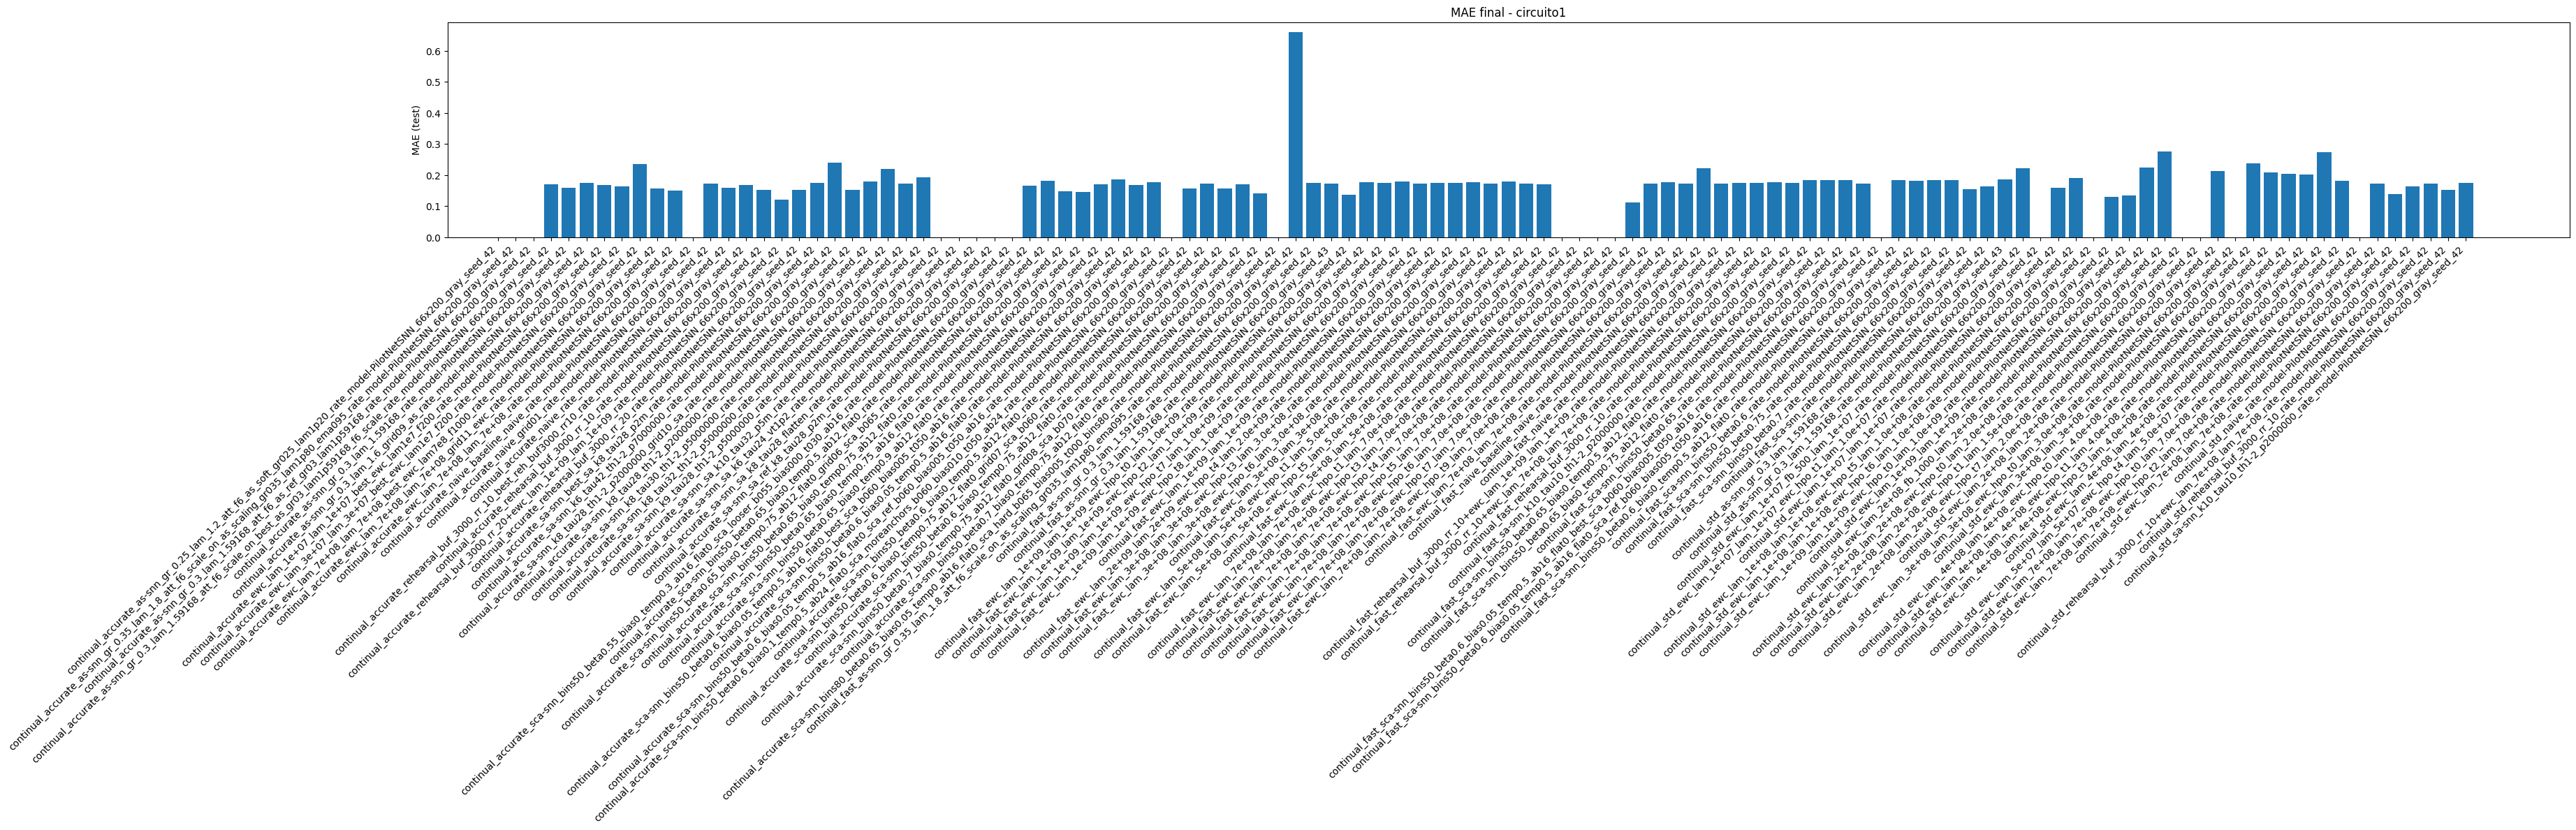

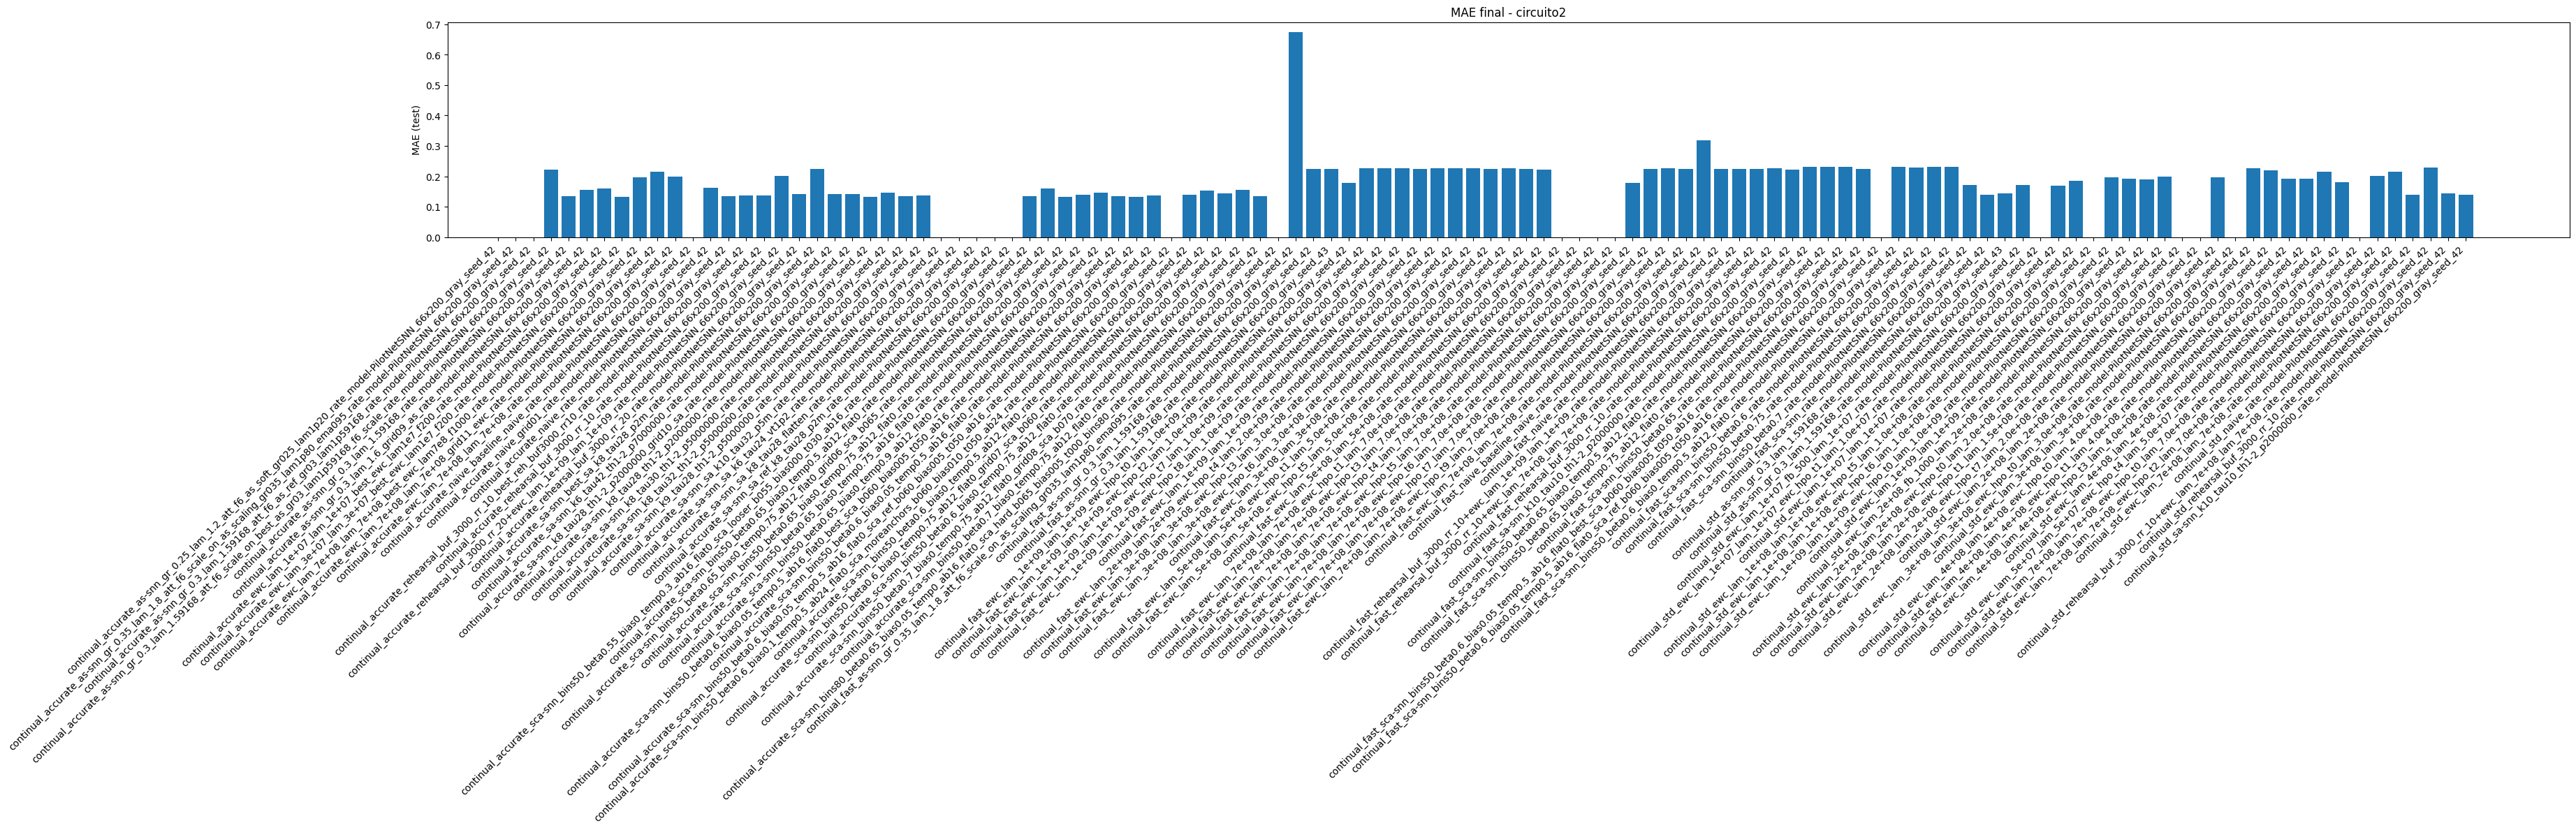

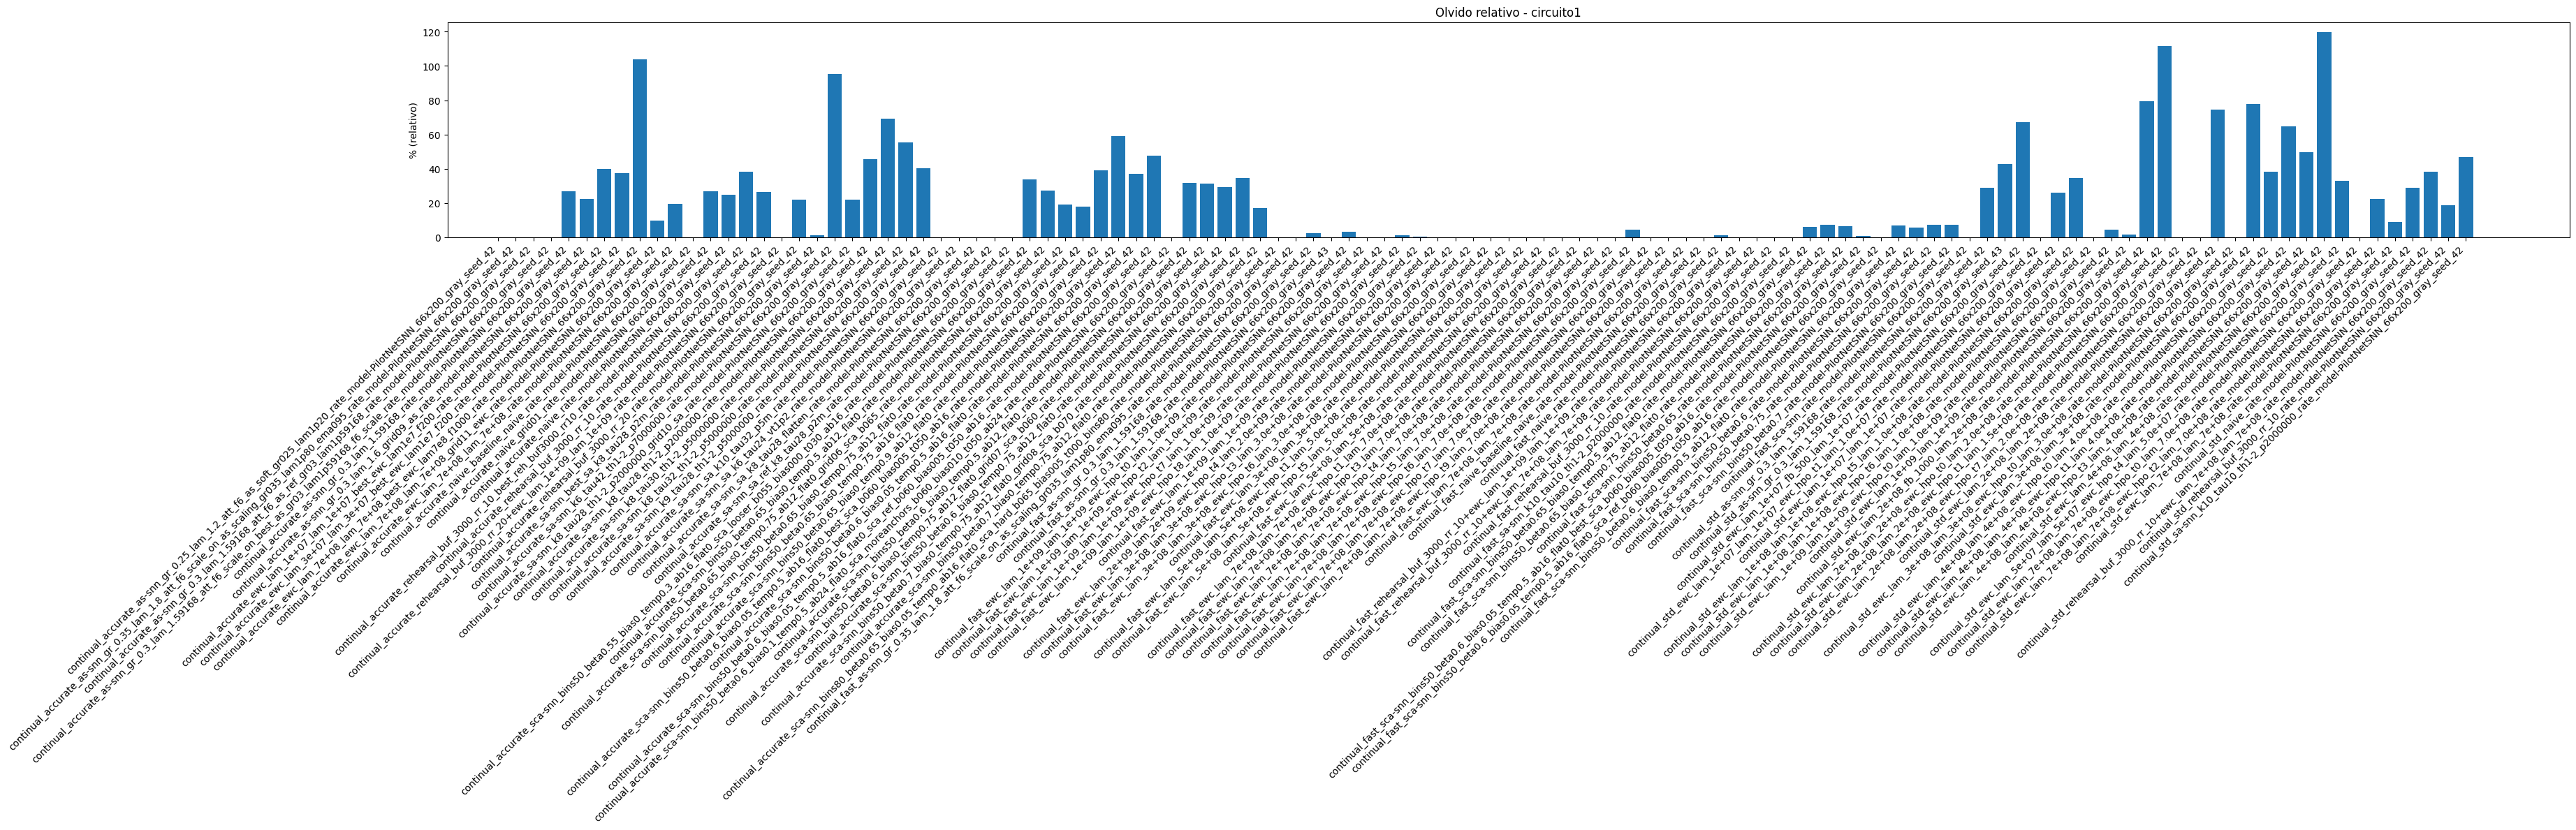

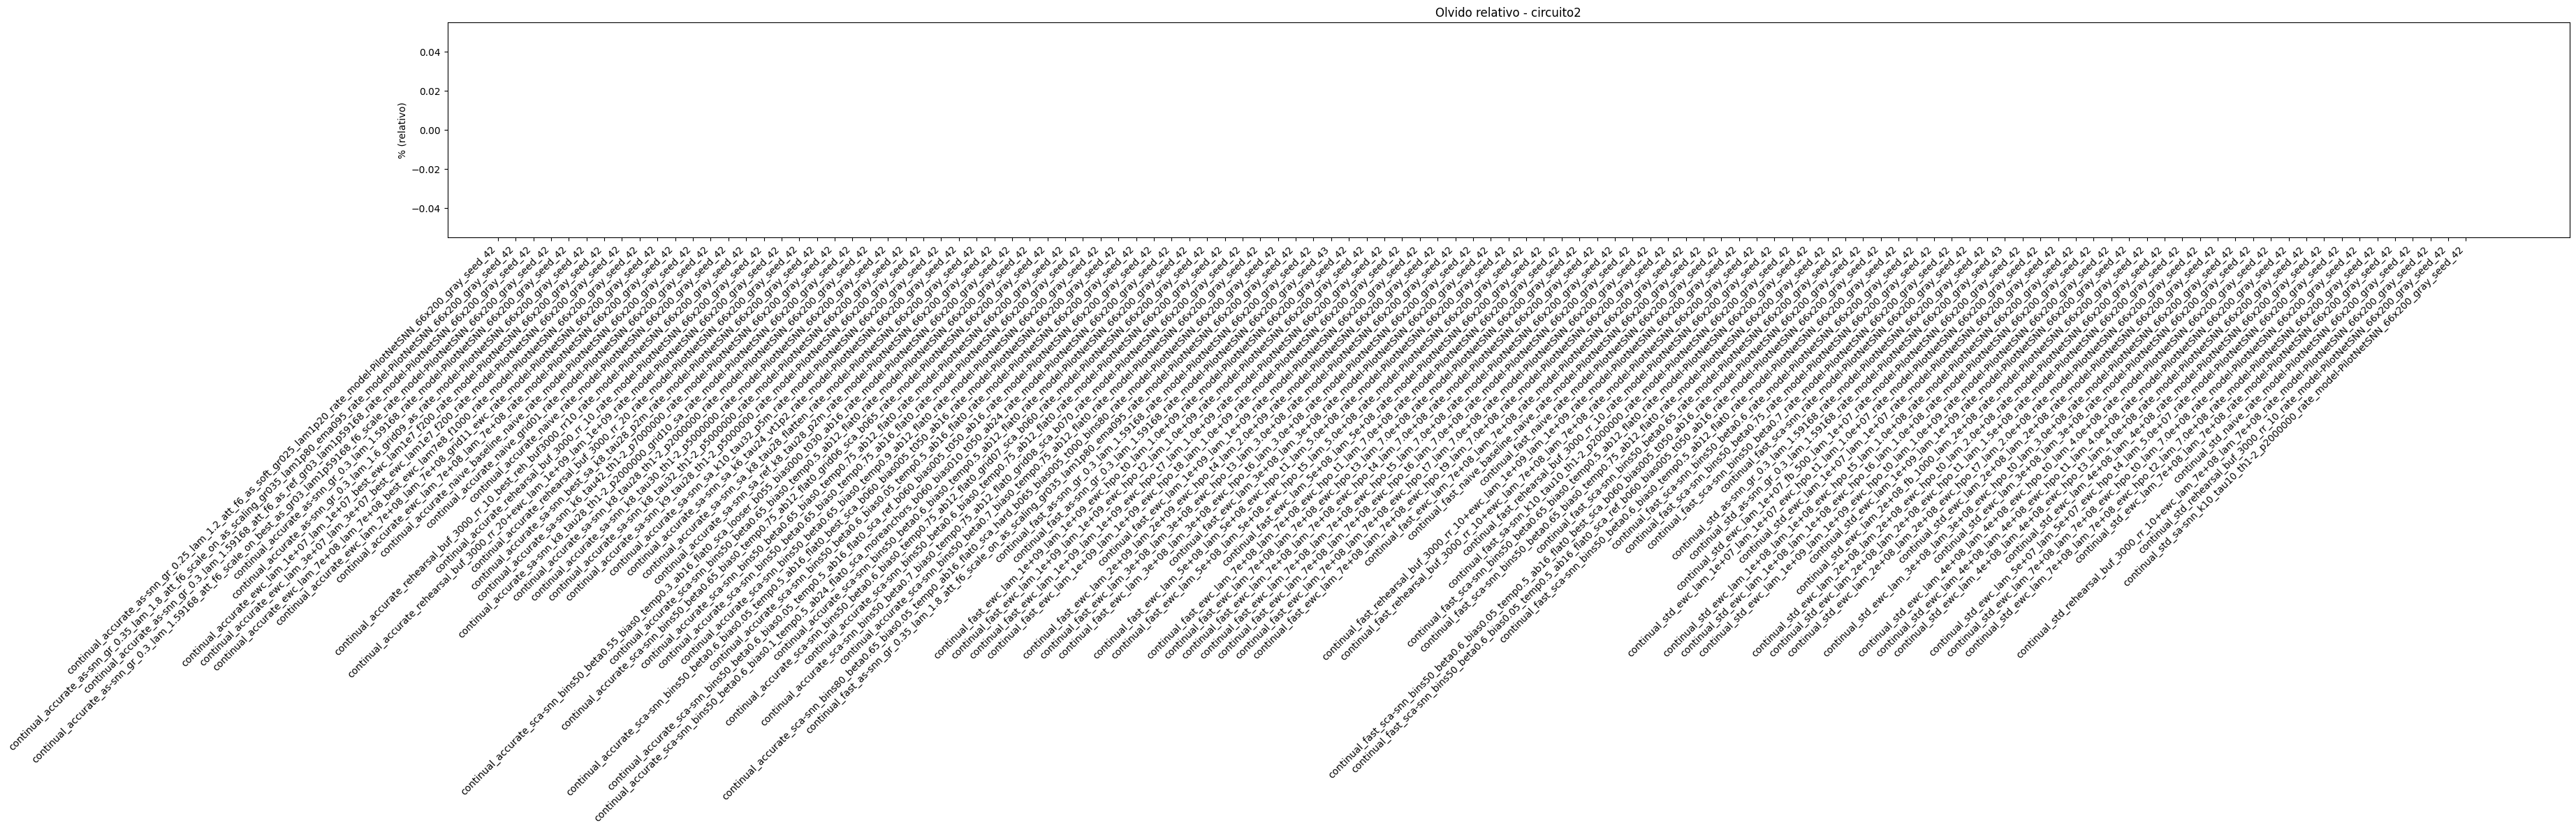

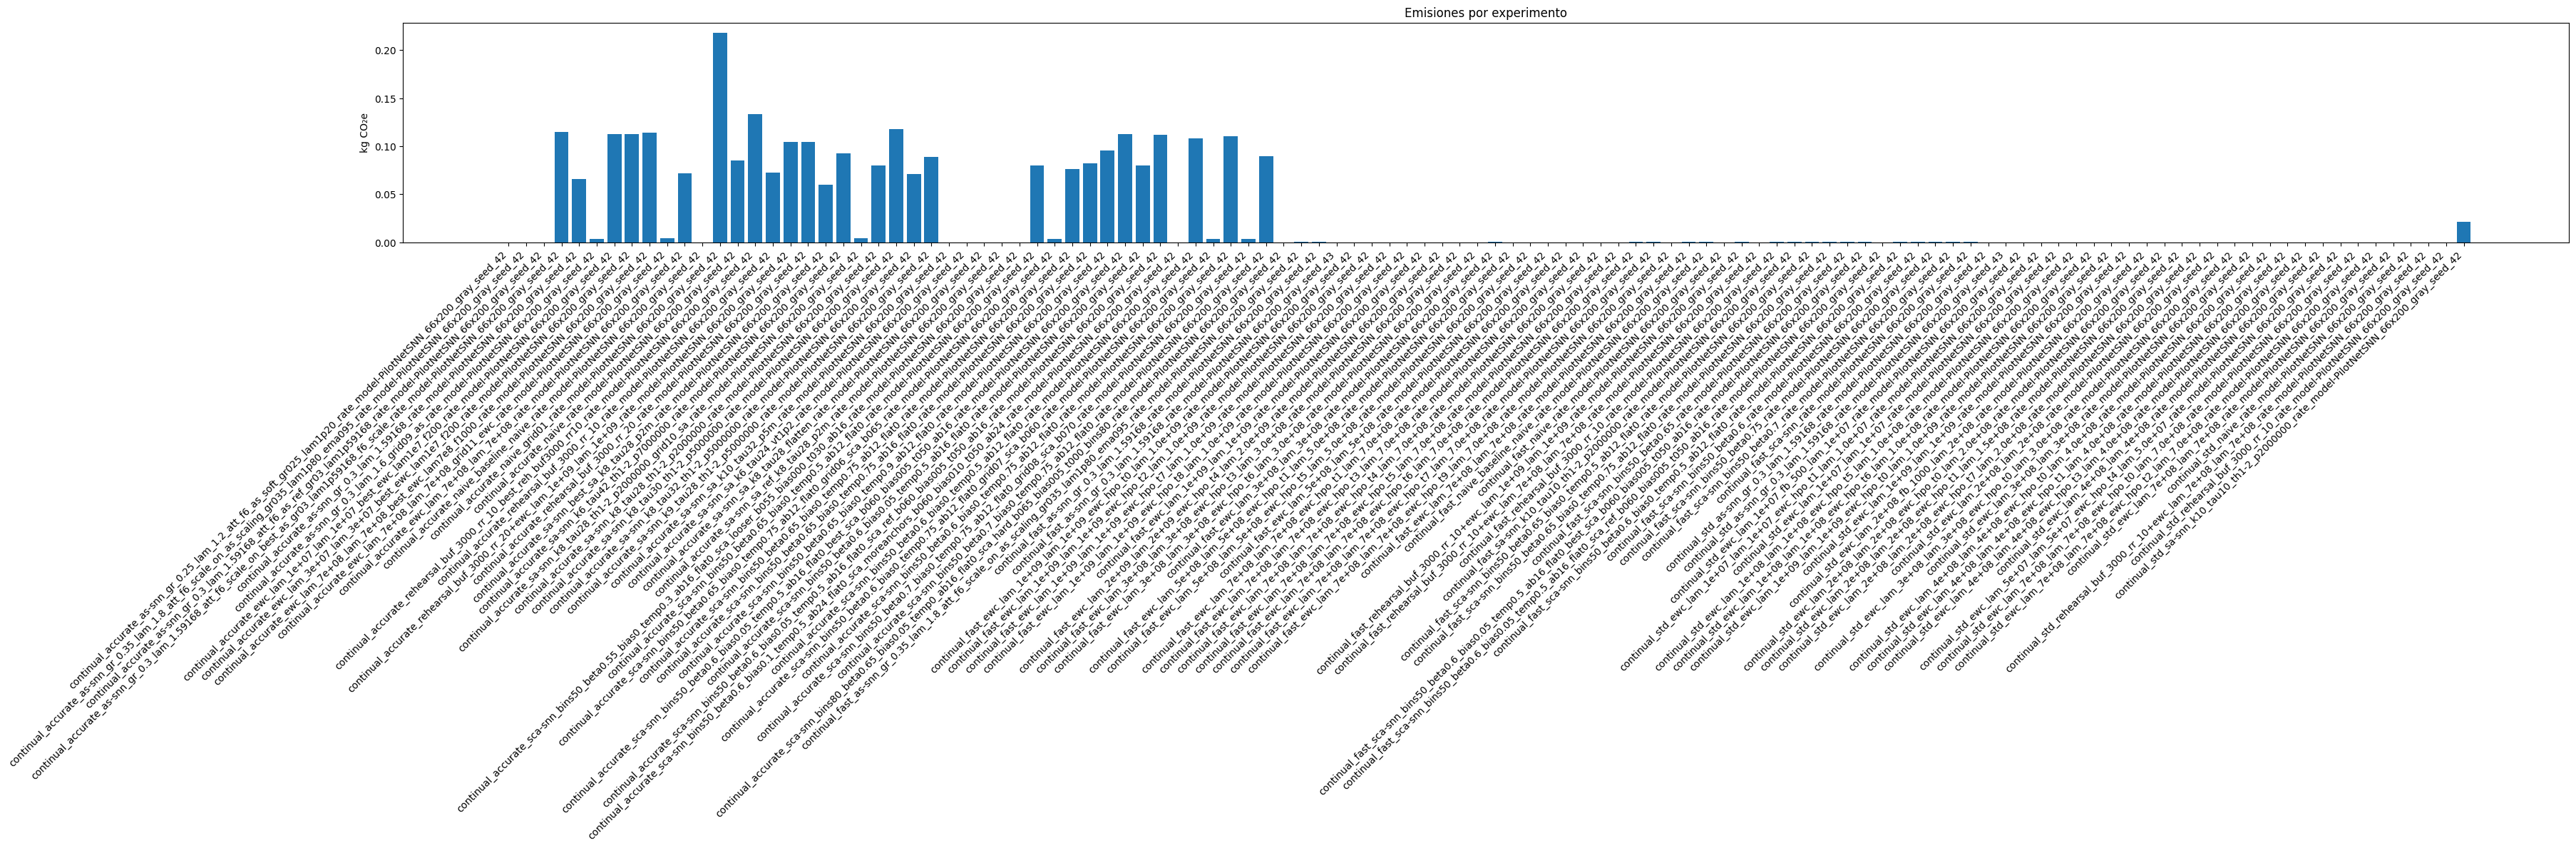

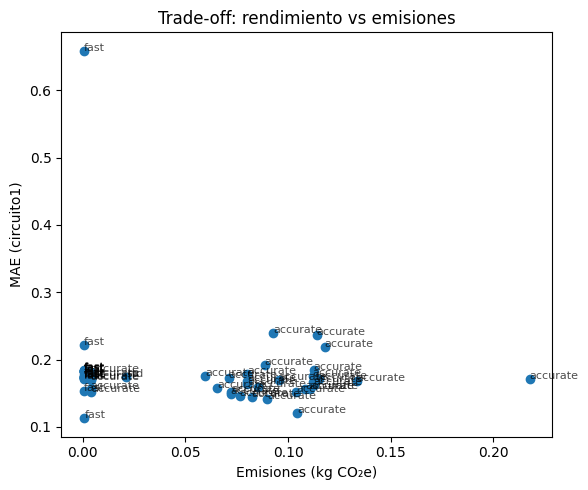

[OK] Gráficas comparativas en: /home/cesar/proyectos/TFM_SNN/outputs/summary/plots
Generando curvas de loss para: continual_fast_naive_baseline_naive_rate_model-PilotNetSNN_66x200_gray_seed_42


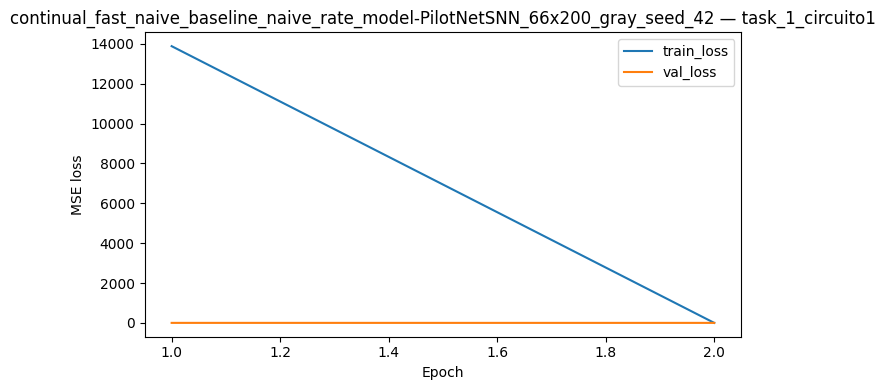

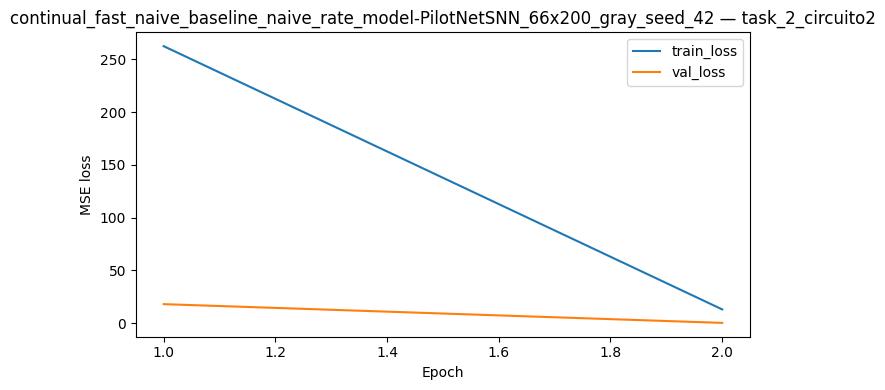

[OK] Curvas de loss en: /home/cesar/proyectos/TFM_SNN/outputs/summary/loss_curves


In [8]:
# =============================================================================
# 7) Resumen y gráficas
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.results_io import build_results_table
from src.plots import plot_across_runs

summary_dir = OUT / "summary"
summary_dir.mkdir(parents=True, exist_ok=True)

def canonical_method(s: str) -> str:
    if not isinstance(s, str): return "unknown"
    t = s.lower()
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t): return "rehearsal+ewc"
    if "sca-snn" in t: return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t): return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t): return "as-snn"
    if "colanet" in t: return "colanet"
    if re.search(r"\bewc\b", t) or "ewc_lam" in t: return "ewc"
    if "rehearsal" in t: return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t: return "naive"
    return t.split("_")[0]

df = build_results_table(OUT)
df["method_base"] = df["method"].astype(str).apply(canonical_method)
display(df)
df.to_csv(summary_dir / "results_table.csv", index=False)
print(f"[OK] Tabla guardada en {summary_dir/'results_table.csv'}")

plots_dir = plot_across_runs(df, summary_dir / "plots")
print("[OK] Gráficas comparativas en:", plots_dir)

# (opcional) Curvas de loss del run más reciente
def plot_losses_for_run(run_dir: Path, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    task_dirs = sorted(run_dir.glob("task_*"))
    if not task_dirs:
        print(f"[WARN] No hay task_* en {run_dir}")
        return
    for td in task_dirs:
        man = None
        for cand in ("manifest.json", "metrics.json"):
            p = td / cand
            if p.exists():
                with open(p, "r", encoding="utf-8") as f:
                    man = json.load(f)
                break
        if man is None:
            print(f"[WARN] Sin manifest/metrics en {td.name}")
            continue
        hist = (man.get("history") or {})
        tr = hist.get("train_loss") or []
        va = hist.get("val_loss") or []
        if not tr and not va:
            print(f"[WARN] {td.name}: sin 'train_loss'/'val_loss'.")
            continue
        plt.figure(figsize=(7,4))
        if tr: plt.plot(range(1, len(tr)+1), tr, label="train_loss")
        if va: plt.plot(range(1, len(va)+1), va, label="val_loss")
        plt.title(f"{run_dir.name} — {td.name}")
        plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend()
        plt.tight_layout()
        plt.savefig(outdir / f"{run_dir.name}__{td.name}_loss.png", dpi=160)
        plt.savefig(outdir / f"{run_dir.name}__{td.name}_loss.svg")
        plt.show()

runs = sorted(OUT.glob("continual_*"), key=lambda p: p.stat().st_mtime, reverse=True)
if runs:
    loss_plots_dir = summary_dir / "loss_curves"
    print("Generando curvas de loss para:", runs[0].name)
    plot_losses_for_run(runs[0], loss_plots_dir)
    print("[OK] Curvas de loss en:", loss_plots_dir)
else:
    print("[INFO] No hay runs en outputs/ todavía.")
